In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve

from joblib import dump

from xgboost import XGBClassifier

In [2]:
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED)

Setup and Load

In [3]:
base_dir = r"D:\Path\to\the\directory\where\the\extracted_mimic_iii_data\is\stored"

In [4]:
train_csv = os.path.join(base_dir, "CLEAN", "train_clean.csv")
test_csv  = os.path.join(base_dir, "CLEAN", "test_clean.csv")
meta_json = os.path.join(base_dir, "CLEAN", "preprocess_metadata.json")

In [5]:
train = pd.read_csv(train_csv)
test  = pd.read_csv(test_csv)

with open(meta_json, "r") as f:
    meta = json.load(f)

label_col = meta["label_col"]
cat_cols  = meta["cat_cols"]
num_cols  = meta["num_cols"]

# X, y
X_train = train[num_cols + cat_cols].copy()
y_train = train[label_col].astype(int).values

X_test  = test[num_cols + cat_cols].copy()
y_test  = test[label_col].astype(int).values

Utility Evaluation

In [6]:
def evaluate(proba, y_true, threshold=0.5, verbose=True):
    pred = (proba >= threshold).astype(int)
    roc  = roc_auc_score(y_true, proba)
    pr   = average_precision_score(y_true, proba)
    f1   = f1_score(y_true, pred)
    if verbose:
        print(f"ROC AUC: {roc:.3f}")
        print(f"PR  AUC: {pr:.3f}")
        print(f"F1     : {f1:.3f}")
        print("\nClassification report:\n", classification_report(y_true, pred, digits=3))
        print("Confusion matrix:\n", confusion_matrix(y_true, pred))
    return {"roc_auc": roc, "pr_auc": pr, "f1": f1}

Logistic Regression (with scaling)

In [7]:
# Preprocessing: impute + scale numerics, impute + one-hot for categoricals
pre_lr = ColumnTransformer([
    ('num', Pipeline([('imp', SimpleImputer(strategy='median')),
                      ('sc',  StandardScaler())]), num_cols),
    ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                      ('oh',  OneHotEncoder(handle_unknown='ignore'))]), cat_cols)
])

In [8]:
# Class weight to help with imbalance
clf_lr = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs', n_jobs=-1)

In [9]:
pipe_lr = Pipeline([('pre', pre_lr), ('clf', clf_lr)])
pipe_lr.fit(X_train, y_train)

proba_lr = pipe_lr.predict_proba(X_test)[:,1]
print("=== Logistic Regression ===")
metrics_lr = evaluate(proba_lr, y_test)

=== Logistic Regression ===
ROC AUC: 0.805
PR  AUC: 0.362
F1     : 0.356

Classification report:
               precision    recall  f1-score   support

           0      0.957     0.730     0.829     10965
           1      0.237     0.720     0.356      1274

    accuracy                          0.729     12239
   macro avg      0.597     0.725     0.592     12239
weighted avg      0.882     0.729     0.779     12239

Confusion matrix:
 [[8009 2956]
 [ 357  917]]


In [10]:
os.makedirs(os.path.join(base_dir, "models"), exist_ok=True)

In [ ]:
dump(pipe_lr, os.path.join(base_dir, "models", "lr_pipeline.joblib"))

Random Forest (no scaling)

In [12]:
# Preprocessing: impute numerics, one-hot for categoricals, no scaling for trees
pre_rf = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), num_cols),
    ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                      ('oh',  OneHotEncoder(handle_unknown='ignore'))]), cat_cols)
])

In [13]:
clf_rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    n_jobs=-1,
    class_weight="balanced_subsample",
    random_state=42
)

In [14]:
pipe_rf = Pipeline([('pre', pre_rf), ('clf', clf_rf)])
pipe_rf.fit(X_train, y_train)

proba_rf = pipe_rf.predict_proba(X_test)[:,1]
print("=== Random Forest ===")
metrics_rf = evaluate(proba_rf, y_test)

=== Random Forest ===
ROC AUC: 0.855
PR  AUC: 0.474
F1     : 0.298

Classification report:
               precision    recall  f1-score   support

           0      0.913     0.990     0.950     10965
           1      0.697     0.189     0.298      1274

    accuracy                          0.907     12239
   macro avg      0.805     0.590     0.624     12239
weighted avg      0.891     0.907     0.882     12239

Confusion matrix:
 [[10860   105]
 [ 1033   241]]


In [ ]:
dump(pipe_rf, os.path.join(base_dir, "models", "rf_pipeline.joblib"))

XGBoost (no scaling)

In [16]:
pre_xgb = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), num_cols),
    ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                      ('oh',  OneHotEncoder(handle_unknown='ignore', sparse=False))]), cat_cols)
], sparse_threshold=0.0)  # force dense for XGB

In [17]:
clf_xgb = XGBClassifier(
    n_estimators=600,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    n_jobs=-1,
    random_state=42,
    eval_metric="auc",
    tree_method="hist",
    scale_pos_weight=(y_train.shape[0] - y_train.sum()) / y_train.sum()  # handle class imbalance
)

In [18]:
pipe_xgb = Pipeline([('pre', pre_xgb), ('clf', clf_xgb)])
pipe_xgb.fit(X_train, y_train)

proba_xgb = pipe_xgb.predict_proba(X_test)[:,1]
print("=== XGBoost ===")
metrics_xgb = evaluate(proba_xgb, y_test)

=== XGBoost ===
ROC AUC: 0.863
PR  AUC: 0.522
F1     : 0.443

Classification report:
               precision    recall  f1-score   support

           0      0.963     0.818     0.885     10965
           1      0.318     0.730     0.443      1274

    accuracy                          0.809     12239
   macro avg      0.641     0.774     0.664     12239
weighted avg      0.896     0.809     0.839     12239

Confusion matrix:
 [[8973 1992]
 [ 344  930]]


In [ ]:
dump(pipe_xgb, os.path.join(base_dir, "models", "xgb_pipeline.joblib"))

Compare results and summary

In [20]:
res = pd.DataFrame([
    {"model": "LogReg", **metrics_lr},
    {"model": "RandomForest", **metrics_rf},
    {"model": "XGBoost", **metrics_xgb},
])
print(res)

res.to_csv(os.path.join(base_dir, "models", "baseline_results.csv"), index=False)

          model   roc_auc    pr_auc        f1
0        LogReg  0.804630  0.362420  0.356324
1  RandomForest  0.855071  0.474470  0.297531
2       XGBoost  0.863186  0.521699  0.443279


In [21]:
# Small validation split from TRAIN ONLY (to avoid leakage)
# Finding the treshold that gives us the best F1 score
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

def fit_and_tune(pipe, name):
    pipe.fit(X_tr, y_tr)
    p_val = pipe.predict_proba(X_val)[:,1]
    prec, rec, thr = precision_recall_curve(y_val, p_val)
    f1s = 2*prec*rec/(prec+rec + 1e-12)
    best_idx = np.nanargmax(f1s)
    best_thr = thr[best_idx] if best_idx < len(thr) else 0.5

    # test set
    p_test = pipe.predict_proba(X_test)[:,1]
    y_pred = (p_test >= best_thr).astype(int)

    out = {
        "model": name,
        "best_thr": float(best_thr),
        "roc_auc": float(roc_auc_score(y_test, p_test)),
        "pr_auc": float(average_precision_score(y_test, p_test)),
        "f1": float(f1_score(y_test, y_pred)),
        "precision_1": float((y_pred[y_test==1].sum()) / max(y_pred.sum(),1)),
        "recall_1": float((y_pred & (y_test==1)).sum() / (y_test==1).sum())
    }
    print(f"\n=== {name} (threshold={best_thr:.3f}) ===")
    print(classification_report(y_test, y_pred, digits=3))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    return out, pipe

# Rebuilding the 3 pipelines the same as previously done
res_tuned = []
m_lr, pipe_lr_tuned = fit_and_tune(pipe_lr, "LogReg")
res_tuned.append(m_lr)

m_rf, pipe_rf_tuned = fit_and_tune(pipe_rf, "RandomForest")
res_tuned.append(m_rf)

m_xgb, pipe_xgb_tuned = fit_and_tune(pipe_xgb, "XGBoost")
res_tuned.append(m_xgb)

pd.DataFrame(res_tuned)


=== LogReg (threshold=0.692) ===
              precision    recall  f1-score   support

           0      0.933     0.907     0.920     10965
           1      0.354     0.440     0.392      1274

    accuracy                          0.858     12239
   macro avg      0.643     0.673     0.656     12239
weighted avg      0.873     0.858     0.865     12239

Confusion matrix:
 [[9941 1024]
 [ 714  560]]

=== RandomForest (threshold=0.295) ===
              precision    recall  f1-score   support

           0      0.937     0.937     0.937     10965
           1      0.456     0.458     0.457      1274

    accuracy                          0.887     12239
   macro avg      0.697     0.697     0.697     12239
weighted avg      0.887     0.887     0.887     12239

Confusion matrix:
 [[10269   696]
 [  690   584]]

=== XGBoost (threshold=0.600) ===
              precision    recall  f1-score   support

           0      0.949     0.889     0.918     10965
           1      0.382     0.59

,model,best_thr,roc_auc,pr_auc,f1,precision_1,recall_1
0,LogReg,0.692228,0.804202,0.361565,0.391882,0.353535,0.439560
1,RandomForest,0.294938,0.854913,0.475754,0.457322,0.456250,0.458399
2,XGBoost,0.600384,0.860636,0.515354,0.464054,0.382308,0.590267


ROC and PR curves

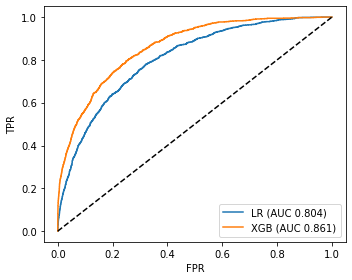

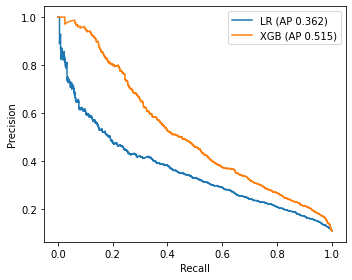

In [22]:
def plot_curves(y_true, probs, labels, fname_prefix):
    plt.figure(figsize=(5,4))
    for p,l in zip(probs, labels):
        fpr,tpr,_ = roc_curve(y_true, p); plt.plot(fpr,tpr,label=f"{l} (AUC {roc_auc_score(y_true,p):.3f})")
    plt.plot([0,1],[0,1],'k--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(base_dir, "FIGS", f"{fname_prefix}_roc.png"), dpi=200)

    plt.figure(figsize=(5,4))
    for p,l in zip(probs, labels):
        pr,rc,_ = precision_recall_curve(y_true, p); ap = average_precision_score(y_true,p)
        plt.plot(rc,pr,label=f"{l} (AP {ap:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(base_dir, "FIGS", f"{fname_prefix}_pr.png"), dpi=200)

p_lr  = pipe_lr.predict_proba(X_test)[:,1]
p_xgb = pipe_xgb.predict_proba(X_test)[:,1]
plot_curves(y_test, [p_lr, p_xgb], ["LR","XGB"], "02_clean")

Calibration curves

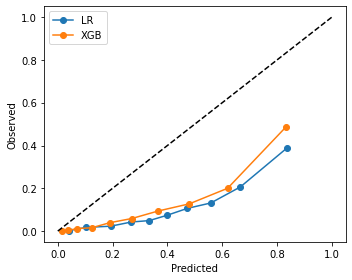

In [23]:
# The closer to the diagonal the better
plt.figure(figsize=(5,4))
for p,l in [(p_lr,"LR"),(p_xgb,"XGB")]:
    frac_pos, mean_pred = calibration_curve(y_test, p, n_bins=10, strategy="quantile")
    plt.plot(mean_pred, frac_pos, marker="o", label=l)
plt.plot([0,1],[0,1],'k--'); plt.xlabel("Predicted"); plt.ylabel("Observed"); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(base_dir, "FIGS", "02_calibration.png"), dpi=200)

Feature importance

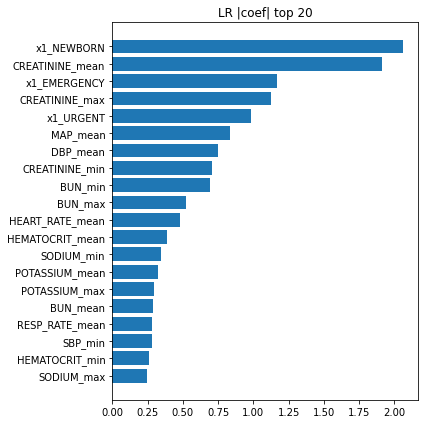

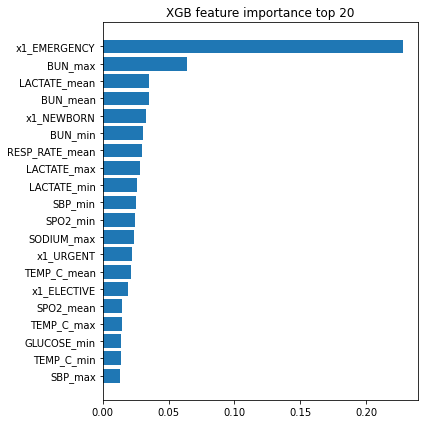

In [24]:
# LR coefficients
lr_clf = pipe_lr.named_steps["clf"]
pre    = pipe_lr.named_steps["pre"]
num_scal = pre.named_transformers_["num"].named_steps["sc"]
cat_oh   = pre.named_transformers_["cat"].named_steps["oh"]
cat_names = list(cat_oh.get_feature_names_out())
feat_names = list(num_cols) + cat_names
coefs = np.abs(lr_clf.coef_.ravel())
order = np.argsort(coefs)[-20:]
plt.figure(figsize=(6,6)); plt.barh([feat_names[i] for i in order], coefs[order]); plt.title("LR |coef| top 20"); plt.tight_layout()
plt.savefig(os.path.join(base_dir, "FIGS", "02_lr_coef.png"), dpi=200)

# XGB gain importance
xgb_clf = pipe_xgb.named_steps["clf"]
imp = xgb_clf.feature_importances_
order = np.argsort(imp)[-20:]
plt.figure(figsize=(6,6)); plt.barh([feat_names[i] for i in order], imp[order]); plt.title("XGB feature importance top 20"); plt.tight_layout()
plt.savefig(os.path.join(base_dir, "FIGS", "02_xgb_importance.png"), dpi=200)

Confusion matrix heatmap at prevalence-matched threshold

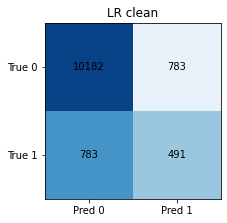

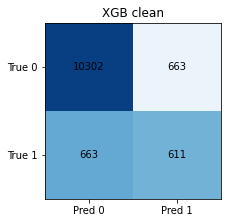

In [25]:
# Confusion Matrix plot
def cm_plot(y, p, title, fname):
    tau = np.quantile(p, 1 - np.mean(y))
    cm = confusion_matrix(y, (p>=tau).astype(int), labels=[0,1])
    cmn = cm / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(3.6,3.2)); plt.imshow(cmn, vmin=0, vmax=1, cmap="Blues")
    for i in range(2):
        for j in range(2):
            plt.text(j, i, f"{cm[i,j]}", ha="center", va="center")
    plt.xticks([0,1],["Pred 0","Pred 1"]); plt.yticks([0,1],["True 0","True 1"])
    plt.title(title); plt.tight_layout(); plt.savefig(os.path.join(base_dir, "FIGS", fname), dpi=200)

cm_plot(y_test, p_lr,  "LR clean",  "02_cm_lr_clean.png")
cm_plot(y_test, p_xgb, "XGB clean", "02_cm_xgb_clean.png")

In [26]:
# AUC and average precision values on the test set for LR and XGB
print(f"LR AUC={roc_auc_score(y_test,p_lr):.3f}  AP={average_precision_score(y_test,p_lr):.3f}")
print(f"XGB AUC={roc_auc_score(y_test,p_xgb):.3f} AP={average_precision_score(y_test,p_xgb):.3f}")

LR AUC=0.804  AP=0.362
XGB AUC=0.861 AP=0.515


In [27]:
# Prevalence (mean of binary labels) on test set
print("Test prevalence:", float(np.mean(y_test)))
leaks = {"LOS","INTIME","OUTTIME","ADMITTIME","DISCHTIME","DEATHTIME","HADM_ID","ICUSTAY_ID","SUBJECT_ID","DIAGNOSIS"}
print("Possible leakage cols present:", [c for c in X_test.columns if c in leaks])

Test prevalence: 0.10409347168886347
Possible leakage cols present: []
